In [1]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from scipy.stats import randint
from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve,classification_report,accuracy_score
from matplotlib import pyplot

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Mount the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Load the files from the google drive
df_apprec=pd.read_csv("/content/gdrive/Shared drives/Team 8-OPIM-5512-Data Science using Python/Project data sets/application_record.csv")
df_credrec=pd.read_csv("/content/gdrive/Shared drives/Team 8-OPIM-5512-Data Science using Python/Project data sets/credit_record.csv")

In [4]:
# Shape of the dataframes
print('Size of the Application dataset is', df_apprec.shape)
print('Size of the credit record dataset is', df_credrec.shape)

Size of the Application dataset is (438557, 18)
Size of the credit record dataset is (1048575, 3)


In [5]:
#unique values
print(df_apprec.nunique())
#data sample
print(df_apprec.head())

ID                     438510
CODE_GENDER                 2
FLAG_OWN_CAR                2
FLAG_OWN_REALTY             2
CNT_CHILDREN               12
AMT_INCOME_TOTAL          866
NAME_INCOME_TYPE            5
NAME_EDUCATION_TYPE         5
NAME_FAMILY_STATUS          5
NAME_HOUSING_TYPE           6
DAYS_BIRTH              16379
DAYS_EMPLOYED            9406
FLAG_MOBIL                  1
FLAG_WORK_PHONE             2
FLAG_PHONE                  2
FLAG_EMAIL                  2
OCCUPATION_TYPE            18
CNT_FAM_MEMBERS            13
dtype: int64
        ID CODE_GENDER  ... OCCUPATION_TYPE CNT_FAM_MEMBERS
0  5008804           M  ...             NaN             2.0
1  5008805           M  ...             NaN             2.0
2  5008806           M  ...  Security staff             2.0
3  5008808           F  ...     Sales staff             1.0
4  5008809           F  ...     Sales staff             1.0

[5 rows x 18 columns]


In [0]:
# find all users' account open month.
begin_month=pd.DataFrame(df_credrec.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'begin_month'}) 
new_data=pd.merge(df_apprec,begin_month,how="left",on="ID") #merge to record data

In [0]:
#Aggrgating the credit record by recoding 1,2,3,4,5 to 1 and X,C values to zero
dfCr=df_credrec["STATUS"].replace({"X": "0", "C": "0", "2":"1", "3":"1", "4":"1", "5":"1"}, inplace=True)

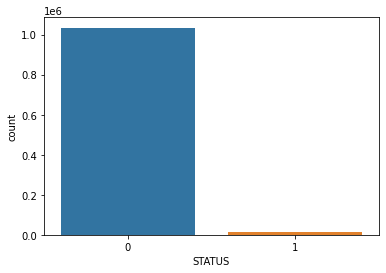

In [8]:
sns.countplot(x='STATUS', data=df_credrec)

In [0]:
#Aggrgating the user IDs based on the maximum value of the staus value
uniq_users=pd.DataFrame(df_credrec.groupby('ID').agg({'STATUS':'max'}))

In [0]:
#Merge the application data with the user credit status data
new_data=pd.merge(df_apprec,uniq_users,how="inner",on="ID") #merge to record data

In [0]:
#Renaming the columns
new_data.rename(columns={'CODE_GENDER':'Gender','FLAG_OWN_CAR':'Car','FLAG_OWN_REALTY':'Reality',
                         'CNT_CHILDREN':'ChldNo','AMT_INCOME_TOTAL':'inc',
                         'NAME_EDUCATION_TYPE':'edutp','NAME_FAMILY_STATUS':'famtp',
                        'NAME_HOUSING_TYPE':'houtp','FLAG_EMAIL':'email',
                         'NAME_INCOME_TYPE':'inctp','FLAG_WORK_PHONE':'wkphone',
                         'FLAG_PHONE':'phone','CNT_FAM_MEMBERS':'famsize',
                        'OCCUPATION_TYPE':'occyp'
                        },inplace=True)

In [12]:
#Masking the null values
new_data.dropna()
new_data = new_data.mask(new_data == 'NULL').dropna()

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [0]:
#Creating dummy variables 
one_hot_train_i = pd.get_dummies(new_data['inctp'])
one_hot_train_e = pd.get_dummies(new_data['edutp'])
one_hot_train_h = pd.get_dummies(new_data['houtp'])
one_hot_train_f = pd.get_dummies(new_data['famtp'])
one_hot_train_o = pd.get_dummies(new_data['occyp'])


In [0]:
new_data['Car'] = new_data['Car'].astype('bool')
new_data['Reality'] = new_data['Reality'].astype('bool')
#new_data['STATUS'] = new_data['STATUS'].astype('bool')
new_data['wkphone']=new_data['wkphone'].astype('str')
new_data['phone']=new_data['phone'].astype('str')
new_data['email']=new_data['email'].astype('str')
new_data['STATUS'] = new_data['STATUS'].astype(np.uint8)
#df_appRec.FLAG_OWN_CAR.map(dict(Y=1, N=0))
#df_appRec.FLAG_OWN_REALTY.map(dict(Y=1, N=0))
new_data['Gender'] = np.where(new_data['Gender'] != 'M', 1, 0)

In [0]:
#Dropping categorical variables and updating with one hot encoded vectors
#new_data.drop(columns=['inctp', 'edutp','occyp','houtp','famtp'], axis = 1, inplace = True)
#new_data = pd.concat([one_hot_train_i, new_data], axis = 1)
#new_data = pd.concat([one_hot_train_e, new_data], axis = 1)
#new_data = pd.concat([one_hot_train_h, new_data], axis = 1)
#new_data = pd.concat([one_hot_train_f, new_data], axis = 1)
#new_data = pd.concat([one_hot_train_o, new_data], axis = 1)

In [0]:
df_final=new_data

In [0]:
# Droping the wkphone, phone and email columns
y=new_data['STATUS']
X = new_data[['Gender','Car','Reality','ChldNo', 'inc','DAYS_BIRTH','DAYS_EMPLOYED','FLAG_MOBIL','famsize']]

In [0]:
#new_data.drop(columns=['inctp', 'edutp','occyp','houtp','famtp'], axis = 1, inplace = True)
X = pd.concat([one_hot_train_i, X], axis = 1)
X = pd.concat([one_hot_train_e, X], axis = 1)
X = pd.concat([one_hot_train_h, X], axis = 1)
X = pd.concat([one_hot_train_f, X], axis = 1)
X = pd.concat([one_hot_train_o, X], axis = 1)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3)

In [0]:
#Logistic regression model for the data
Log_classifier = LogisticRegression(class_weight='balanced')
scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(Log_classifier, X_train, y_train, scoring=scoring, cv=20)
sorted(scores.keys())
LR_fit_time = scores['fit_time'].mean()
LR_score_time = scores['score_time'].mean()
LR_accuracy = scores['test_accuracy'].mean()
LR_precision = scores['test_precision_macro'].mean()
LR_recall = scores['test_recall_macro'].mean()
LR_f1 = scores['test_f1_weighted'].mean()
LR_roc = scores['test_roc_auc'].mean()
LR_cm = scores['test_roc_auc'].mean()

In [21]:
#Confusion matrix for logistic regression
Log_classifier.fit(X_train, y_train)
#y_pred = cross_val_predict(random_forest, X_test,y_test, cv=10)
y_pred=Log_classifier.predict(X_test)
confusion_matrix(y_test, y_pred)


array([[4013, 2545],
       [ 573,  410]])

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.513


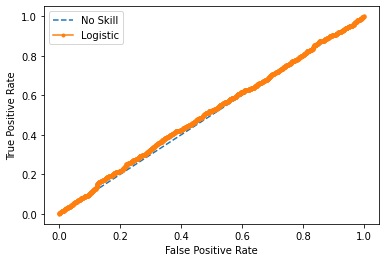

In [22]:
#Precision recall curve for Logistic regression
ns_probs = [0 for _ in range(len(y_test))]
Log_classifier.fit(X_train, y_train)
lr_probs = Log_classifier.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [0]:
#Fit the decision tree model on training data 
decision_tree = DecisionTreeClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(decision_tree, X_train, y_train, scoring=scoring, cv=20)

sorted(scores.keys())
dtree_fit_time = scores['fit_time'].mean()
dtree_score_time = scores['score_time'].mean()
dtree_accuracy = scores['test_accuracy'].mean()
dtree_precision = scores['test_precision_macro'].mean()
dtree_recall = scores['test_recall_macro'].mean()
dtree_f1 = scores['test_f1_weighted'].mean()
dtree_roc = scores['test_roc_auc'].mean()


In [24]:
#Confusion Matrix for Decision tree model 
decision_tree.fit(X_train, y_train)
#y_pred = cross_val_predict(random_forest, X_test,y_test, cv=10)
y_pred=decision_tree.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[6262,  296],
       [ 682,  301]])

No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.727


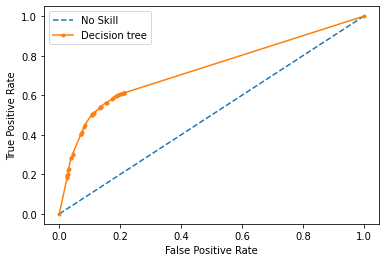

In [25]:
#Precision recall curve for Decision tree
ns_probs = [0 for _ in range(len(y_test))]
decision_tree.fit(X_train, y_train)
lr_probs = decision_tree.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Decision Tree: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Decision tree')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [26]:
gdclf = GradientBoostingClassifier()
scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(gdclf, X_train, y_train, scoring=scoring, cv=20)
sorted(scores.keys())
gb_fit_time = scores['fit_time'].mean()
gb_score_time = scores['score_time'].mean()
gb_accuracy = scores['test_accuracy'].mean()
gb_precision = scores['test_precision_macro'].mean()
gb_recall = scores['test_recall_macro'].mean()
gb_f1 = scores['test_f1_weighted'].mean()
gb_roc = scores['test_roc_auc'].mean()

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
#Confusion Matrix for GB 
gdclf.fit(X_train, y_train)
#y_pred = cross_val_predict(random_forest, X_test,y_test, cv=10)
y_pred=gdclf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[6555,    3],
       [ 977,    6]])

No Skill: ROC AUC=0.500
Gradient Boost: ROC AUC=0.598


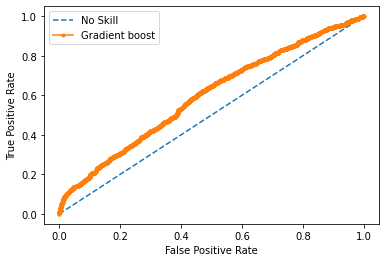

In [28]:
#Precision recall curve for GB
ns_probs = [0 for _ in range(len(y_test))]
gdclf.fit(X_train, y_train)
lr_probs = gdclf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Gradient Boost: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Gradient boost')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [0]:
random_forest = RandomForestClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(random_forest, X_train, y_train, scoring=scoring, cv=20)

sorted(scores.keys())
forest_fit_time = scores['fit_time'].mean()
forest_score_time = scores['score_time'].mean()
forest_accuracy = scores['test_accuracy'].mean()
forest_precision = scores['test_precision_macro'].mean()
forest_recall = scores['test_recall_macro'].mean()
forest_f1 = scores['test_f1_weighted'].mean()
forest_roc = scores['test_roc_auc'].mean()

In [30]:
#Confusion Matrix for random forest
random_forest.fit(X_train, y_train)
#y_pred = cross_val_predict(random_forest, X_test,y_test, cv=10)
y_pred=random_forest.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[6302,  256],
       [ 685,  298]])

No Skill: ROC AUC=0.500
Random forest: ROC AUC=0.774


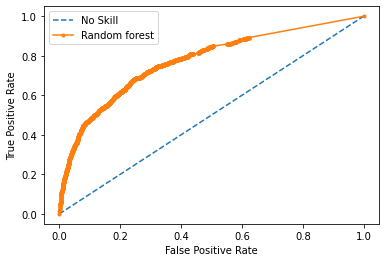

In [31]:
#Precision recall curve for Random forest
ns_probs = [0 for _ in range(len(y_test))]
random_forest.fit(X_train, y_train)
lr_probs = random_forest.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random forest: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Random forest')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [35]:
#Model Comparison
  models_rfecv = pd.DataFrame({
      'Model'       : ['Logistic Regression', 'Decision Tree', 'Random Forest','Gradient Boost'],
      'Fitting time': [LR_fit_time, dtree_fit_time, forest_fit_time,gb_fit_time],
      'Scoring time': [LR_score_time, dtree_score_time, forest_score_time,gb_score_time],
      'Accuracy'    : [LR_accuracy, dtree_accuracy, forest_accuracy,gb_accuracy],
      'Precision'   : [LR_precision, dtree_precision, forest_precision,gb_precision],
      'Recall'      : [LR_recall, dtree_recall, forest_recall,gb_recall],
      'F1_score'    : [LR_f1, dtree_f1, forest_f1,gb_f1],
      'AUC_ROC'     : [LR_roc, dtree_roc, forest_roc,gb_roc],
      }, columns = ['Model', 'Fitting time', 'Scoring time', 'Accuracy', 'Precision', 'Recall', 'F1_score', 'AUC_ROC'])

  models_rfecv.sort_values(by='Accuracy', ascending=False)


,Model,Fitting time,Scoring time,Accuracy,Precision,Recall,F1_score,AUC_ROC
3,Gradient Boost,2.662893,0.013354,0.881885,0.794795,0.508485,0.829008,0.592974
2,Random Forest,2.115097,0.083625,0.881202,0.708886,0.629359,0.867293,0.780789
1,Decision Tree,0.188503,0.010419,0.875462,0.689141,0.627128,0.863198,0.732947
0,Logistic Regression,0.154146,0.015586,0.587509,0.506991,0.515892,0.659496,0.525986


In [0]:
def evalPerformance(test_algo_obtained_labels, test_labels):
	a, b, c, d = 0, 0, 0, 0
	test_labels = np.array(test_labels)
	test_algo_obtained_labels = np.array(test_algo_obtained_labels)
	test_algo_obtained_labels = test_algo_obtained_labels.astype(np.float)
	for i in range(0, len(test_labels)):
		if(test_labels[i] == test_algo_obtained_labels[i] and test_labels[i] == 1.0):
			a += 1
		elif(test_labels[i] == 1.0 and test_algo_obtained_labels[i] == 0.0):
			b += 1
		elif(test_labels[i] == 0.0 and test_algo_obtained_labels[i] == 1.0):
			c += 1
		elif(test_labels[i] == test_algo_obtained_labels[i] and test_labels[i] == 0.0):
			d += 1
	accuracy = 0.0
	precision = 0.0
	recall = 0.0
	f_measure = 0.0
	if(a+b+c+d != 0):
		accuracy = float(a+d)/(a+b+c+d)
	if(a+c != 0):
		precision = a / float(a+c)
	if(a+b != 0):
		recall = a/float(a+b)
	if(2*a + b + c != 0):
		f_measure = 2*a/float(2*a + b + c)
	print(" Accuracy is : " + str(accuracy)),
	print(" Precision is : " + str(precision))
	print(" Recall is : " + str(recall))
	print(" F Measure is : " + str(f_measure))
	print()
	return accuracy, precision, recall, f_measure

In [0]:
#SMote
y1=df_final['STATUS']
X1 = df_final[['Gender','Car','Reality','ChldNo', 'inc','DAYS_BIRTH','DAYS_EMPLOYED','FLAG_MOBIL','famsize']]

In [38]:
from imblearn.over_sampling import SMOTE
X_balance,Y_balance = SMOTE().fit_sample(X,y)
X_balance = pd.DataFrame(X_balance,columns=X.columns)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [39]:
shape = np.shape(X_balance)
print("Shape of the dataset ",shape)


Shape of the dataset  (44090, 48)


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_balance,Y_balance, 
                                                    stratify=Y_balance, test_size=0.3,
                                                    random_state = 10086)

In [41]:
rf= RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [42]:
y_pred=rf.predict(X_test)
evalPerformance(y_pred,y_test)

 Accuracy is : 0.9162319497996523
 Precision is : 0.9155971614072173
 Recall is : 0.9169817027067897
 F Measure is : 0.9162889090359625



(0.9162319497996523,
 0.9155971614072173,
 0.9169817027067897,
 0.9162889090359625)

No Skill: ROC AUC=0.500
Random forest: ROC AUC=0.964


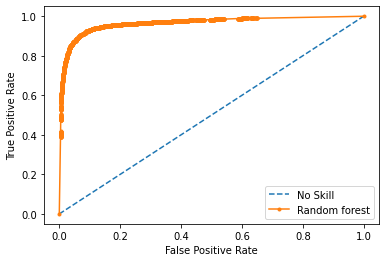

In [43]:
#Precision recall curve for Random forest
ns_probs = [0 for _ in range(len(y_test))]
rf.fit(X_train, y_train)
lr_probs = rf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random forest: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Random forest')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

[7.29683991e-03 3.93491401e-03 5.26413515e-03 2.08203639e-02
 1.42131047e-02 1.31255563e-03 1.14296304e-02 1.43851957e-03
 4.75888244e-02 1.90776852e-03 1.49237707e-02 7.71115566e-03
 2.77249145e-03 9.11091808e-04 2.65987523e-02 9.61144805e-04
 4.83675167e-03 1.57013600e-03 1.29685794e-02 3.97757098e-02
 8.85290238e-03 2.30744306e-02 3.14976768e-03 1.16890681e-03
 1.45843236e-02 5.44761451e-03 1.24455704e-03 3.07402186e-03
 7.59733758e-03 4.09649771e-04 3.59299995e-02 7.14344887e-03
 1.97493688e-03 4.10646206e-02 4.01153706e-02 9.47650603e-04
 1.43885647e-02 5.22343367e-05 5.38793964e-02 5.30679076e-02
 0.00000000e+00 0.00000000e+00 3.48178562e-02 1.04897588e-01
 1.36505011e-01 1.35094372e-01 0.00000000e+00 4.32812906e-02]


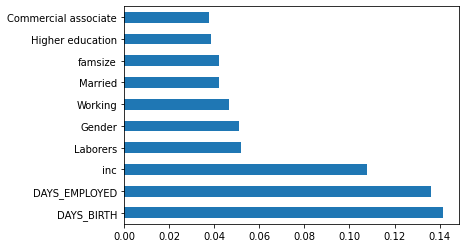

In [44]:
random_forest.fit(X_test,y_test)
print(rf.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(random_forest.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [45]:
from sklearn.feature_selection import SelectFromModel
Xf_train, Xf_test, yf_train, yf_test = train_test_split(X_balance,Y_balance, 
                                                    stratify=Y_balance, test_size=0.3,
                                                    random_state = 10084)
 #Select features which have higher contribution in the final prediction

sfm = SelectFromModel(rf, threshold=0.02) 
sfm.fit(Xf_train,yf_train)


SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,

In [47]:
#Transform input dataset

Xf_train_1 = sfm.transform(Xf_train) 
Xf_test_1 = sfm.transform(Xf_test)

#Check the size and shape of new dataset 
print("Size of Data set before feature selection: %.2f MB"%(Xf_train_1.nbytes/1e6))

shape = np.shape(Xf_train_1)

print("Shape of the dataset ",shape)

Size of Data set before feature selection: 3.70 MB
Shape of the dataset  (30863, 15)


In [0]:
rf.fit(Xf_train_1, yf_train) 

#evaluate the model on test data
pre = rf.predict(Xf_test_1) 

[0.02483708 0.05934497 0.02903975 0.05743479 0.02417957 0.0404654
 0.04238105 0.04752139 0.06397936 0.06268645 0.03612329 0.12506858
 0.16964776 0.1662926  0.05099796]


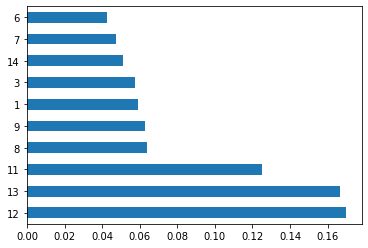

In [49]:
print(rf.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(rf.feature_importances_)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

 Accuracy is : 0.9170635820669842
 Precision is : 0.91264023934181
 Recall is : 0.9224372543090414
 F Measure is : 0.9175125949319498

No Skill: ROC AUC=0.500
Random forest: ROC AUC=0.965


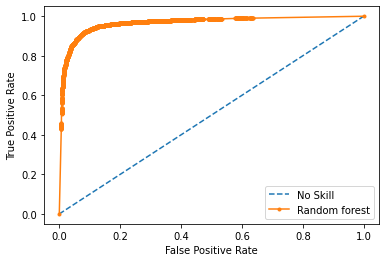

In [50]:
evalPerformance(pre,yf_test)
#Precision recall curve for Random forest
ns_probs = [0 for _ in range(len(yf_test))]
rf.fit(Xf_train_1, yf_train)
lr_probs = rf.predict_proba(Xf_test_1)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(yf_test, ns_probs)
lr_auc = roc_auc_score(yf_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random forest: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(yf_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(yf_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Random forest')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [52]:
#Table of Probability of defaults
preds_df = pd.DataFrame(lr_probs, columns = ['prob_default'])
true_df = pd.DataFrame(yf_test, columns = ['true data'])

# Concatenate and print the two data frames for comparison
concate_data = pd.concat([true_df, preds_df])
preds_df.head()

,prob_default
0,0.060000
1,0.123619
2,0.808877
3,0.000000
4,0.023333
